Copyright (c) 2017 Andrew Johnson, Dan Kotlyar, GTRC

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Results Reader

##  Basic operations

This notebook demonstrates the capabilities of the serpentTools to read Serpent results files. SERPENT [1] produces a result file (i.e. _res.m), containing general results (e.g. k-eff), metadata (e.g. title) and homogenized cross-sections. The homogenized cross-section sets are printed in the results file for all the requested universes. The ResultsReader is capable of reading this file, and storing the data inside univ objects. Each such object has methods and attributes that should ease analysis.

In [1]:
%matplotlib notebook
import numpy as np
import serpentTools
from serpentTools.settings import rc

In [2]:
%time
resFile = 'InnerAssembly_res.m'
res = serpentTools.read(resFile)

Wall time: 0 ns


# Metadata

metadata is a collective data that describe the problem.
The following data is included: titles, data paths, and other descriptive data exist on the reader 

In [11]:
print(res.metadata['version'])  # Serpent version used for the execution
print(res.metadata['decayDataFilePath'])  # Directory path for data libraries
print(res.metadata['inputFileName'])  # Directory path for data libraries

Serpent 2.1.30
/nv/hp22/dkotlyar6/data/Codes/DATA/endfb7/sss_endfb7.dec
InnerAssembly


Obtain all the variables in the metadata through '.keys()'

In [4]:
res.metadata.keys()

dict_keys(['version', 'compileDate', 'debug', 'title', 'confidentialData', 'inputFileName', 'workingDirectory', 'hostname', 'cpuType', 'cpuMhz', 'startDate', 'completeDate', 'pop', 'cycles', 'skip', 'batchInterval', 'srcNormMode', 'seed', 'ufsMode', 'ufsOrder', 'neutronTransportMode', 'photonTransportMode', 'groupConstantGeneration', 'b1Calculation', 'b1BurnupCorrection', 'implicitReactionRates', 'optimizationMode', 'reconstructMicroxs', 'reconstructMacroxs', 'doubleIndexing', 'mgMajorantMode', 'spectrumCollapse', 'mpiTasks', 'ompThreads', 'mpiReproducibility', 'ompReproducibility', 'ompHistoryProfile', 'shareBufArray', 'shareRes2Array', 'xsDataFilePath', 'decayDataFilePath', 'sfyDataFilePath', 'nfyDataFilePath', 'braDataFilePath'])

In [17]:
# Grep the value of a certain key, e.g. simulation start date
res.metadata['startDate']

'Sat Apr 28 06:09:54 2018'

In [5]:
# statistics used for the execution (histories, inactive and active cycles)
print(res.metadata['pop'], res.metadata['skip']  , res.metadata['cycles'])

[ 5000.] [ 10.] [ 50.]


In [18]:
# Obtain the version defined in the settings
print('User defined version: {}'.format(rc['serpentVersion']))
# Obtain the version actually used in the execution
print('Used version: {}'.format(res.metadata['version']))

User defined version: 2.1.29
Used version: Serpent 2.1.30


Check if the used defined version and the utilized Serpent version match

In [19]:
# Compare
rc['serpentVersion'] in res.metadata['version']

False

# Results Data (resdata)

Results are stored as a function of time/burnup/index and include integral parameters of the system.
Results, such as k-eff, total flux, execution times are included in .resdata. Some results include values and uncertainities (e.g. criticality) and some just the values (e.g. CPU resources). 

In [7]:
print(res.resdata['absKeff'])  # Values (1st col.) + std (2nd col.) 

[[  1.29160000e+00   9.00000000e-04]
 [  1.29500000e+00   9.30000000e-04]
 [  1.29172000e+00   9.10000000e-04]
 [  1.29172000e+00   7.80000000e-04]
 [  1.29312000e+00   6.80000000e-04]
 [  1.29140000e+00   7.80000000e-04]]


In [8]:
print(res.resdata['burnup']) # burnup intervals (MWd/kg) 
print(res.resdata['burnDays']) # time points (days)


[[ 0.        0.      ]
 [ 0.1       0.100001]
 [ 1.        1.00001 ]
 [ 2.        2.00001 ]
 [ 3.        3.00003 ]
 [ 4.        4.00004 ]]
[[  0.     ]
 [  1.20048]
 [ 12.0048 ]
 [ 24.0096 ]
 [ 36.0144 ]
 [ 48.0192 ]]


obtain all the variables in the resdata

In [9]:
res.resdata.keys()

dict_keys(['minMacroxs', 'dtThresh', 'stFrac', 'dtFrac', 'dtEff', 'reaSamplingEff', 'reaSamplingFail', 'totColEff', 'avgTrackingLoops', 'avgTracks', 'avgRealCol', 'avgVirtCol', 'avgSurfCross', 'lostParticles', 'cycleIdx', 'sourcePopulation', 'meanPopSize', 'meanPopWgt', 'simulationCompleted', 'totCpuTime', 'runningTime', 'initTime', 'processTime', 'transportCycleTime', 'burnupCycleTime', 'batemanSolutionTime', 'mpiOverheadTime', 'estimatedRunningTime', 'cpuUsage', 'transportCpuUsage', 'ompParallelFrac', 'availMem', 'allocMemsize', 'memsize', 'xsMemsize', 'matMemsize', 'resMemsize', 'miscMemsize', 'unknownMemsize', 'unusedMemsize', 'totCells', 'unionCells', 'neutronErgTol', 'neutronErgNe', 'neutronEmin', 'neutronEmax', 'uresDiluCut', 'uresEmin', 'uresEmax', 'uresAvail', 'uresUsed', 'totNuclides', 'totTransportNuclides', 'totDosimetryNuclides', 'totDecayNuclides', 'totPhotonNuclides', 'totReaChannels', 'totTransmuRea', 'useDelnu', 'useUres', 'useDbrc', 'implCapt', 'implNxn', 'implFiss', 

## Plotting resdata

Basic 1-D plotting capabilities are not yet avaialble in the parser. Plotting capability is planned to be added in the near-term. 

<IPython.core.display.Javascript object>


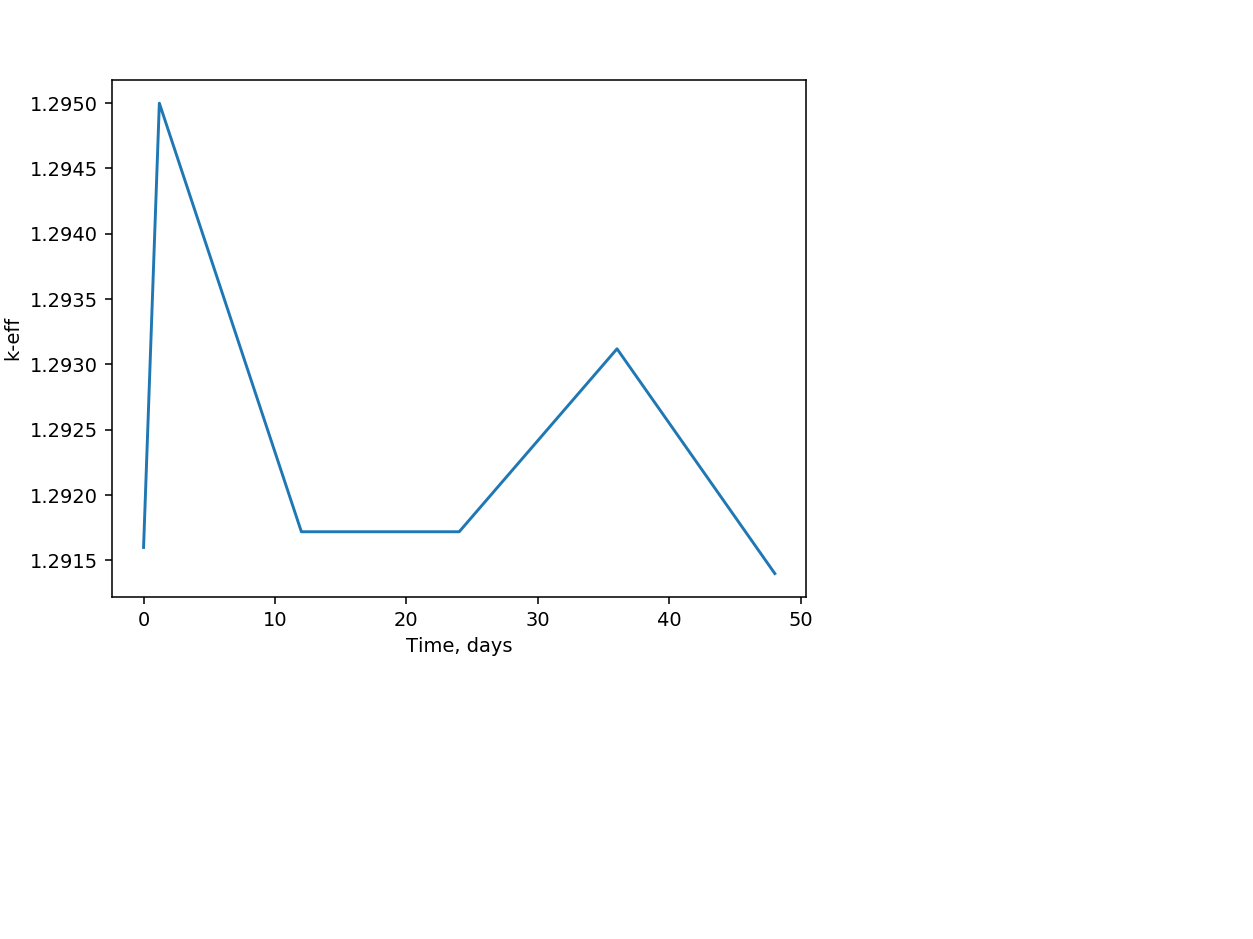

(<matplotlib.text.Text at 0x2923226d748>,
 <matplotlib.text.Text at 0x292323c2be0>)

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
xdata = res.resdata['burnDays'][:]
ydata = res.resdata['absKeff'][:,0]
plt.plot(xdata, ydata)
plt.xlabel('Time, days'), plt.ylabel('k-eff')               